# imports

In [34]:
import os
import torch
from torch import nn
from torchvision import models
from torchsummary import summary
import torchinfo
import json
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import random
import spacy
from torch.nn.utils.rnn import pad_sequence

# set the device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# set hyperparameters

In [3]:
#TODO

# Collate

In [27]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # Get the image and change it's dimention [C, H, W] → [1, C, H, W]
        imgs = [item[0].unsqueeze(0) for item in batch]
        # Concatenate all images along dim=0 to form a batch tensor of shape [batch_size, C, H, W]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        # Use pad_sequence to pad variable-length sequences to the same length
        # batch_first=True argument means the output tensor has shape (batch_size, max_seq_length)
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        return imgs, targets

# Vocabulary

In [18]:
# Download with: python -m spacy download en
spacy_eng = spacy.load("en_core_web_sm")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, tokens):
        frequencies = Counter()

        for cap_tokens in tokens:
            # Update word frequency
            frequencies.update(cap_tokens)

        # Get the words with frequency more than a threshold
        words = [w for w in frequencies.keys() if frequencies[w] > self.freq_threshold]
        # Use v + 4 because indexes 0 to 3 are already taken
        self.stoi.update({k: v + 4 for v, k in enumerate(words)})
        self.itos.update({v + 4: k for v, k in enumerate(words)})

    def numericalize(self, text, tokenized_text):
        # Use tokens from dataset or use spacy
        # tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

    def textualize(self, embedding):
        # Convert tensor to list
        embedding_list = embedding.tolist()
        return " ".join(self.itos[num] for num in embedding_list)

# load data

In [51]:
class ImageCaptionDataset(Dataset):
    def __init__(self, image_folder, captions_dict, tokens, captions_per_image=5, transform=None, freq_threshold=5):
        self.image_folder = image_folder
        self.captions_per_image = captions_per_image
        self.captions_dict = self.sample_captions(captions_dict)  # Dictionary with {image_name: [caption1, caption2, ...]}
        self.tokens = tokens
        self.captions = [caption for captions in captions_dict.values() for caption in captions] # all captions together
        # + 2 to consider start and end tokens
        self.caption_lengths = [len(token) + 2 for token in self.tokens]
        self.image_names = list(captions_dict.keys())  # List of unique image names
        self.transform = transform
        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        # self.vocab.build_vocabulary(self.captions)
        self.vocab.build_vocabulary(self.tokens)

    # # Based on image
    # def __len__(self):
    #     return len(self.image_names)

    # def __getitem__(self, idx):
    #     image_name = self.image_names[idx]
    #     image_path = os.path.join(self.image_folder, image_name)

    #     # Open image
    #     image = Image.open(image_path).convert("RGB")
        
    #     # Apply transformations
    #     if self.transform:
    #         image = self.transform(image)

    #     # Get all captions for the image
    #     captions = self.captions_dict[image_name]

    #     # Get one of the captions randomly for training
    #     random_idx = random.randrange(len(captions))
    #     caption = captions[random_idx]
        
    #     numericalized_caption = [self.vocab.stoi["<start>"]]
    #     numericalized_caption += self.vocab.numericalize(caption, self.tokens[idx * self.captions_per_image + random_idx])
    #     numericalized_caption.append(self.vocab.stoi["<end>"])
    #     numericalized_caption = torch.tensor(numericalized_caption)

    #     return image, numericalized_caption

    # Based on caption
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image_name = self.image_names[idx // self.captions_per_image]
        image_path = os.path.join(self.image_folder, image_name)

        # Open image
        image = Image.open(image_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        caption = self.captions[idx]
        
        numericalized_caption = [self.vocab.stoi["<start>"]]
        numericalized_caption += self.vocab.numericalize(caption, self.tokens[idx])
        numericalized_caption.append(self.vocab.stoi["<end>"])
        numericalized_caption = torch.tensor(numericalized_caption)

        # Also return length and all captions for validation or testing ?
        return image, numericalized_caption

    def sample_captions(self, img_captions):
        # Set a specific number of captions for all images
        modified_captions_dict = {}
        for img, captions in img_captions.items():
            if len(captions) < self.captions_per_image:
                new_captions = captions + [random.choice(captions) for _ in range(self.captions_per_image - len(captions))]
            else:
                new_captions = random.sample(captions, k=self.captions_per_image)
            # Sanity check
            assert len(new_captions) == self.captions_per_image
            modified_captions_dict[img] = new_captions        
            
        return modified_captions_dict

In [52]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

# image_folder = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"  
image_folder = "/kaggle/input/flickr8kimagescaptions/flickr8k/images/"
# karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr30k.json" 
karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr8k.json"

In [53]:
# Load Karpathy split JSON
with open(karpathy_json_path, "r") as f:
    data = json.load(f)

# Organize images by split
split_data = {"train": {}, "val": {}, "test": {}}
token_data = {"train": [], "val": [], "test": []}

for img in data["images"]:
    image_name = img["filename"]
    split = img["split"]  # Can be "train", "val", or "test"
    
    captions = [sent["raw"] for sent in img["sentences"]]  # Extract all 5 captions
    split_data[split][image_name] = captions  # Store in respective split
    
    tokens = [sent["tokens"] for sent in img["sentences"]]  # Extract all tokens
    token_data[split] += tokens

# Now we have:
# split_data["train"], split_data["val"], split_data["test"]


In [54]:
# Load different splits
train_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["train"], 
    token_data["train"], 
    captions_per_image=5,
    transform=transform, 
    freq_threshold=3
)
val_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["val"], 
    token_data["val"], 
    captions_per_image=5,
    transform=transform,
    freq_threshold=3
)
test_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["test"], 
    token_data["test"], 
    captions_per_image=5,
    transform=transform,
    freq_threshold=3
)

pad_idx = train_dataset.vocab.stoi["<pad>"]
# Create DataLoaders
train_loader = DataLoader(train_dataset, collate_fn=MyCollate(pad_idx=pad_idx), batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, collate_fn=MyCollate(pad_idx=pad_idx), batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, collate_fn=MyCollate(pad_idx=pad_idx), batch_size=4, shuffle=False)

# visualize data

Batch Size: 4
Image Tensor Shape: torch.Size([4, 3, 256, 256])
First Caption: tensor([   1,   12,  967,    7,    3,  513,   48,  138,  930,  151,    3, 2318,
           2,    0,    0,    0,    0])
First caption converted: <start> the airplane is <unk> smoke and looks like it <unk> crash <end> <pad> <pad> <pad> <pad>


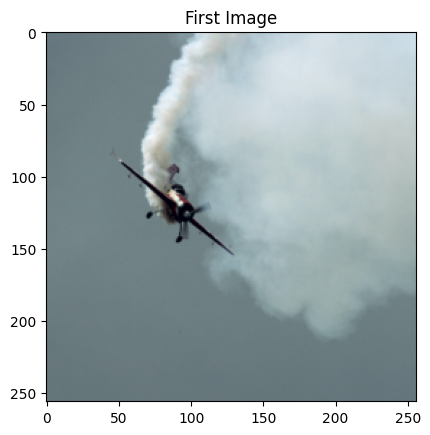

In [45]:
# Test the dataloader
# Fetch one batch
images, captions = next(iter(train_loader))

print(f"Batch Size: {len(images)}")
print(f"Image Tensor Shape: {images.shape}")  # Should be [batch_size, 3, 256, 256]
image = images[0].permute(1, 2, 0).numpy()
image = image * 0.225 + 0.45  # De-normalize
plt.title("First Image")
plt.imshow(image)
print(f"First Caption: {captions[0]}")
text_caption = train_dataset.vocab.textualize(captions[0])
print(f"First caption converted: {text_caption}")

In [47]:
def get_all_caps(dataset, idx):
    image_name = dataset.image_names[idx]
    return dataset.captions_dict[image_name]

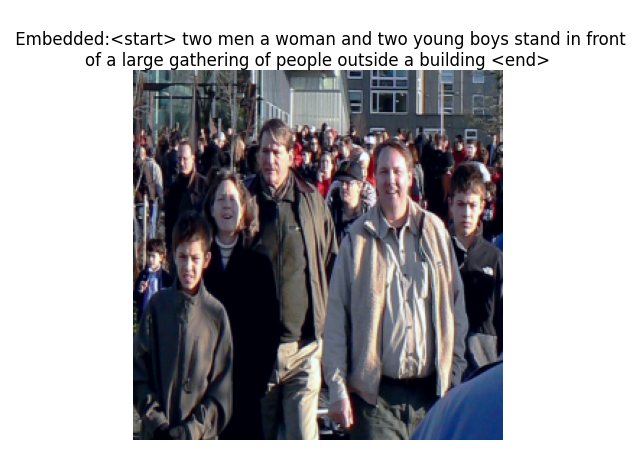

In [59]:
# Visualize a sample
def show_sample(dataset, idx):
    image, caption = dataset[idx]
    image = image.permute(1, 2, 0).numpy()
    image = image * 0.225 + 0.45  # De-normalize
    text_caption = dataset.vocab.textualize(caption)
    # all_caps = "\n".join(get_all_caps(dataset, idx))
    plt.imshow(image)
    # Use this when the idx is for images not captios
    # plt.title(all_caps + '\n Embedded:' + text_caption, fontsize=12, wrap=True)
    plt.title('\n Embedded:' + text_caption, fontsize=12, wrap=True)
    plt.axis('off')
    plt.show()

show_sample(train_dataset, random.randint(0, len(train_dataset)))

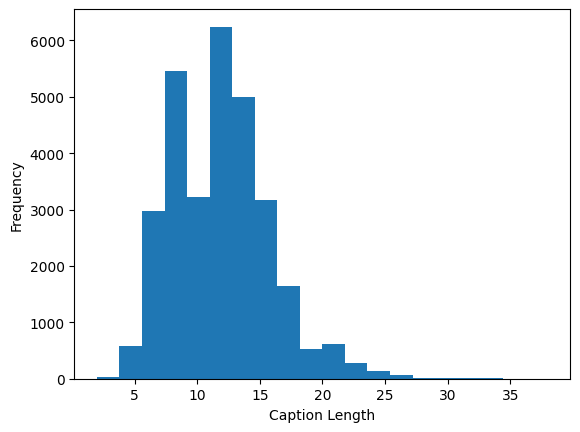

In [14]:
# Caption Length Analysis
caption_lengths = train_dataset.caption_lengths
plt.hist(caption_lengths, bins=20)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


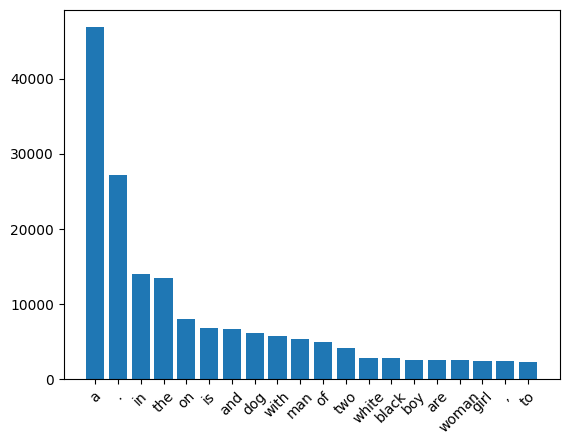

In [50]:
# Word Frequency
all_captions = [caption for caption in train_dataset.captions]

nltk.download('punkt')
all_words = nltk.tokenize.word_tokenize(" ".join(all_captions).lower())
word_freq = Counter(all_words)

# Plot top 20 words
plt.bar(*zip(*word_freq.most_common(20)))
plt.xticks(rotation=45)
plt.show()

# model

In [37]:
model = models.resnet101(pretrained=True)
# model = models.vgg16(pretrained=True) 
# model = models.maxvit_t(pretrained=True) 
# model = models.efficientnet_b0(pretrained=True)

# model = models.mobilenet_v3_small(pretrained=True)
# model = models.densenet201(pretrained=True)
# model = models.inception_v3(pretrained=True)
print(torchinfo.summary(model, input_size=(4, 3, 256, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [4, 1000]                 --
├─Conv2d: 1-1                            [4, 64, 128, 128]         9,408
├─BatchNorm2d: 1-2                       [4, 64, 128, 128]         128
├─ReLU: 1-3                              [4, 64, 128, 128]         --
├─MaxPool2d: 1-4                         [4, 64, 64, 64]           --
├─Sequential: 1-5                        [4, 256, 64, 64]          --
│    └─Bottleneck: 2-1                   [4, 256, 64, 64]          --
│    │    └─Conv2d: 3-1                  [4, 64, 64, 64]           4,096
│    │    └─BatchNorm2d: 3-2             [4, 64, 64, 64]           128
│    │    └─ReLU: 3-3                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [4, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-5             [4, 64, 64, 64]           128
│    │    └─ReLU: 3-6                    [4, 64, 64, 64]           --
│ 

In [32]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

for name, layer in model.named_children():
    print(name, ":", layer)

Total Parameters: 44,549,160
Trainable Parameters: 44,549,160
conv1 : Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 : BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu : ReLU(inplace=True)
maxpool : MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 : Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=

In [48]:
# feature extractor
class Encoder(nn.Module):
    def __init__(self, fine_tune=True):
        super(Encoder, self).__init__()
        self.fine_tune = fine_tune
        model = models.resnet101(pretrained=True)

        # model = models.vgg16(pretrained=True) 
        # model = models.maxvit_t(pretrained=True) 
        # model = models.efficientnet_b0(pretrained=True)
        
        # Remove linear and pool layers (since we're not doing classification)
        modules = list(model.children())[:-2]
        # nn.Sequential allows you to chain layers together without writing a forward pass manually
        self.model = nn.Sequential(*modules)
        self.set_grad()
    
    def forward(self, images):
        x = self.model(images) # (batch_size, 2048, image_size/32, image_size/32) => [4, 2048, 8, 8]
        x = x.permute(0, 2, 3, 1)
        return x
        
    def set_grad(self):
        # UNFREEZE only the last few layers (4th ResNet block)
        for name, param in self.model.named_parameters():
            if "layer4" in name:  # Last residual block (closest to output)
                param.requires_grad = self.fine_tune  # Trainable
            else:
                param.requires_grad = False  # Frozen
        

In [49]:
model = Encoder()
print(model(torch.randn(1, 3, 256, 256)).shape)

torch.Size([1, 8, 8, 2048])


loss and optimizer

# train

# validate

# test on new data

# TTS

# Save outputs for next time

In [ ]:
!zip -r saved_data.zip /kaggle/working/